In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, test_df = data_loader.load_and_preprocess_data("1d", 0.25, 1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df_split['mood'].max() + 1

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-18 15:13:40,449] A new study created in memory with name: no-name-b7d588b1-9946-4866-b4b0-813bb96d0675
[I 2025-04-18 15:13:45,376] Trial 0 finished with value: 0.4681664854288101 and parameters: {'hidden_dim': 113, 'id_embed_dim': 13, 'lr': 0.0018290305221790848, 'batch_size': 32, 'alpha': 0.11388129814345592}. Best is trial 0 with value: 0.4681664854288101.
[I 2025-04-18 15:13:45,641] Trial 1 finished with value: 0.523064736276865 and parameters: {'hidden_dim': 123, 'id_embed_dim': 14, 'lr': 0.00015132697900167012, 'batch_size': 32, 'alpha': 0.045487882563767096}. Best is trial 0 with value: 0.4681664854288101.
[I 2025-04-18 15:13:45,811] Trial 2 finished with value: 1.8916876912117004 and parameters: {'hidden_dim': 87, 'id_embed_dim': 4, 'lr': 0.00010031469977455742, 'batch_size': 64, 'alpha': 0.2815102541617919}. Best is trial 0 with value: 0.4681664854288101.
[I 2025-04-18 15:13:46,047] Trial 3 finished with value: 0.7950034514069557 and parameters: {'hidden_dim': 46, 'i

Best hyperparams: {'hidden_dim': 48, 'id_embed_dim': 10, 'lr': 0.003587120013846666, 'batch_size': 64, 'alpha': 0.010239038262565874}


In [6]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [7]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1000)

Epoch 1: train loss = 0.4274, val loss = 0.2782
Epoch 2: train loss = 0.1921, val loss = 0.1144
Epoch 3: train loss = 0.0939, val loss = 0.0780
Epoch 4: train loss = 0.0692, val loss = 0.0640
Epoch 5: train loss = 0.0602, val loss = 0.0569
Epoch 6: train loss = 0.0553, val loss = 0.0538
Epoch 7: train loss = 0.0519, val loss = 0.0535
Epoch 8: train loss = 0.0494, val loss = 0.0533
Epoch 9: train loss = 0.0470, val loss = 0.0525
Epoch 10: train loss = 0.0450, val loss = 0.0535
Epoch 11: train loss = 0.0429, val loss = 0.0530
Epoch 12: train loss = 0.0410, val loss = 0.0530
Epoch 13: train loss = 0.0399, val loss = 0.0534
Epoch 14: train loss = 0.0387, val loss = 0.0572
Epoch 15: train loss = 0.0379, val loss = 0.0562
Epoch 16: train loss = 0.0367, val loss = 0.0551
Epoch 17: train loss = 0.0358, val loss = 0.0561
Epoch 18: train loss = 0.0348, val loss = 0.0578
Epoch 19: train loss = 0.0340, val loss = 0.0574
Epoch 20: train loss = 0.0330, val loss = 0.0571
Epoch 21: train loss = 0.0319

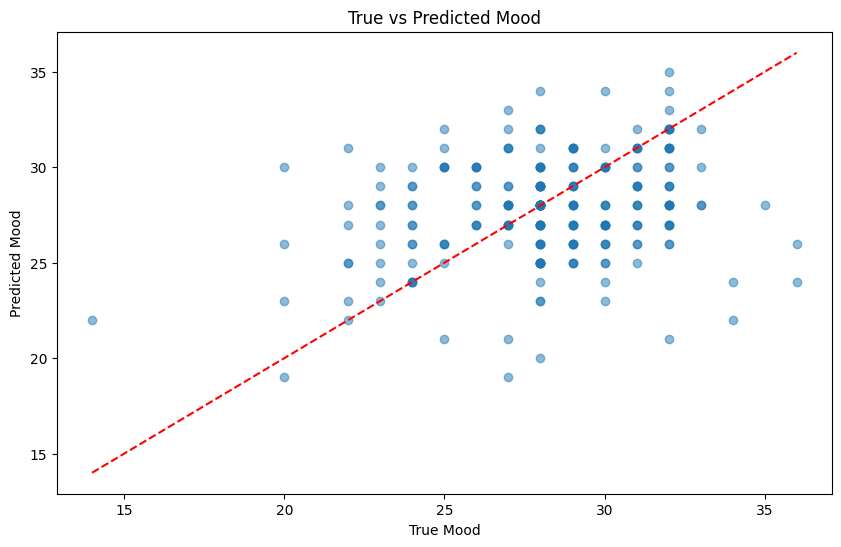

In [8]:
plot_mood_predictions(model, val_loader, device)

In [9]:
from mood_RNN_classifier import get_accuracy_rate
accuracy = get_accuracy_rate(model, val_loader, device)

Accuracy: 0.1914


In [10]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    15
1   AS14.02                    28
2   AS14.03                    33
3   AS14.05                     0
4   AS14.06                     2
5   AS14.07                    34
6   AS14.08                    24
7   AS14.09                    33
8   AS14.12                    22
9   AS14.13                    33
10  AS14.14                    34
11  AS14.15                    33
12  AS14.16                    23
13  AS14.17                    22
14  AS14.19                    34
15  AS14.20                    33
16  AS14.23                     2
17  AS14.24                    34
18  AS14.25                    22
19  AS14.26                    31
20  AS14.27                    33
21  AS14.28                    28
22  AS14.29                    31
23  AS14.30                    33
24  AS14.31                    15
25  AS14.32                    19
26  AS14.33                    33


In [12]:
train_df_split = train_df_split.sort_values('mood')
train_df_split['mood'].unique(), train_df_split['mood'].value_counts()

(array([12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 38], dtype=int32),
 mood
 28    236
 29    108
 30    101
 32     97
 26     92
 31     78
 27     77
 25     54
 24     52
 33     17
 34     11
 22     10
 23      8
 35      5
 21      5
 20      3
 18      3
 14      2
 19      2
 36      2
 15      2
 12      1
 16      1
 38      1
 Name: count, dtype: int64)